In [7]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))



In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Now you can import the LinearRegression class
from modules.LinearRegression import LinearRegression 
lr = LinearRegression(learning_rate = 0.001, n_iters=1000, batch_size = 32, init_method = 'random', loss_function='mse')
lr.load_dataset(X_train_scaled, y_train.reshape(-1, 1))
_, _, loss = lr.fit()

Epoch 1/1000, Loss: 2.8895547549111282
Epoch 101/1000, Loss: 0.559912573843616
Epoch 201/1000, Loss: 0.5393471795483179
Epoch 301/1000, Loss: 0.5324475144336143
Epoch 401/1000, Loss: 0.5289883309867496
Epoch 501/1000, Loss: 0.5269107057289457
Epoch 601/1000, Loss: 0.5255251091521511
Epoch 701/1000, Loss: 0.5245342956650065
Epoch 801/1000, Loss: 0.523791939053735
Epoch 901/1000, Loss: 0.523213482860556


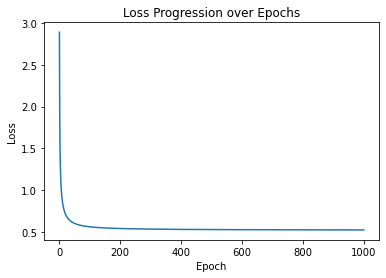

In [11]:
# prompt: Take the loss array and create a line plot showing the loss progression with epochs please

import matplotlib.pyplot as plt

# Assuming 'loss' is the array containing the loss values for each epoch
plt.plot(range(1, lr.n_iters + 1), loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression over Epochs')
plt.show()
